In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import data_preprocessing

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Data Exploration

## Connectivity matrices

In [7]:
european_babies_connectivity_structural_total=pd.read_csv('./preprocessed_data/european_babies_connectivity_structural_total.csv')

In [10]:
def calc_zero_proportion(column):
    return(column==0).sum()/len(column)

zero_proportions_features=european_babies_connectivity_structural_total.iloc[:,1:4005].agg(calc_zero_proportion)

In [11]:
print(f'removed {(zero_proportions_features>0).sum()} features, in which at least 1 of subjects registered zeros values ')
european_babies_connectivity_structural_reduced=european_babies_connectivity_structural_total.drop(columns=zero_proportions_features.index[zero_proportions_features>0])
#european_babies_connectivity_structural_reduced is the reduced version with non-zero features

removed 3268 features, in which at least 1 of subjects registered zeros values 


After retaining only features that are present in all individuals, I have 737 features left.
* Univariate test to check significance of the features to the target. f-regression (https://stackoverflow.com/questions/52461893/univariate-linear-regression-tests-for-feature-selection)
* Check correlation between the features, and the target.

In [37]:
import statsmodels.api as sm
import tqdm

In [38]:
PRS_thresholds=['PRS_0.1', 'PRS_0.2', 'PRS_0.3', 'PRS_0.4', 'PRS_0.5', 'PRS_1']
model_list={}
for threshold in tqdm.tqdm(PRS_thresholds):
    X=european_babies_connectivity_structural_reduced[['Gestation age','Age at scan','Gender','Anc_PC1','Anc_PC2','Anc_PC3',threshold]].copy()
    X=sm.add_constant(X)
    model_list[threshold]={}
    for connection in european_babies_connectivity_structural_reduced.columns[1:737]:
        y=european_babies_connectivity_structural_reduced[connection]
        model=sm.OLS(y,X).fit()
        model_list[threshold][connection]=list(model.pvalues)
        model_list[threshold][connection].append(threshold)

100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


In [56]:
p_val_table=list()
for (threshold,threshold_dict) in model_list.items():
    p_val_table.append(pd.DataFrame(threshold_dict).T)

p_val_table=pd.concat(p_val_table)
p_val_table.reset_index(level=p_val_table.index.names, inplace=True)
p_val_table.columns=['Connection','const_pval','GA.at.birth_pval','PMA.at.birth_pval','Gender_pval','Anc_PC1_pval','Anc_PC2_pval','Anc_PC3_pval','prs_pval','PRS_threshold']
p_val_table

,Connection,const_pval,GA.at.birth_pval,PMA.at.birth_pval,Gender_pval,Anc_PC1_pval,Anc_PC2_pval,Anc_PC3_pval,prs_pval,PRS_threshold
0,SFGdor.L_PreCG.L,0.00086719,0.569753,1.39899e-11,0.801099,0.757543,0.721102,0.350536,0.744581,PRS_0.1
1,SFGdor.R_PreCG.R,0.0402177,0.743427,6.09361e-09,0.956274,0.220398,0.40223,0.125609,0.395809,PRS_0.1
2,ORBsup.L_SFGdor.L,0.0936701,0.853169,4.40663e-05,0.328966,0.66355,0.145167,0.886726,0.381603,PRS_0.1
3,ORBsup.R_SFGdor.R,0.0192224,0.567164,1.10987e-05,0.411281,0.573657,0.499154,0.591581,0.241759,PRS_0.1
4,MFG.L_PreCG.L,0.00991911,0.732644,1.47583e-11,0.687673,0.628449,0.766311,0.209862,0.941021,PRS_0.1
...,...,...,...,...,...,...,...,...,...,...
4411,ITG.R_THA.R,0.179591,0.0684506,1.16857e-09,0.0956929,0.792626,0.881749,0.630159,0.964759,PRS_1
4412,ITG.R_STG.R,0.0219742,0.335795,5.47484e-10,0.571478,0.609824,0.325032,0.146053,0.770854,PRS_1
4413,ITG.R_TPOsup.R,0.121152,0.353316,3.76877e-08,0.12031,0.657796,0.984404,0.76685,0.506335,PRS_1
4414,ITG.R_MTG.R,0.0305752,0.401398,2.80239e-11,0.235746,0.530787,0.563978,0.307437,0.65399,PRS_1


In [65]:
p_val_table.sort_values('prs_pval')

,Connection,const_pval,GA.at.birth_pval,PMA.at.birth_pval,Gender_pval,Anc_PC1_pval,Anc_PC2_pval,Anc_PC3_pval,prs_pval,PRS_threshold
541,THA.L_CAU.L,0.152243,0.57565,4.55379e-10,0.109875,0.378566,0.171805,0.33104,0.00226938,PRS_0.1
220,SOG.L_PCG.L,3.90113e-06,0.174551,1.15502e-10,0.257451,0.112897,0.518425,0.0885944,0.00341529,PRS_0.1
1277,THA.L_CAU.L,0.129199,0.58214,5.64291e-10,0.107869,0.326763,0.210872,0.330581,0.00357156,PRS_0.2
4221,THA.L_CAU.L,0.0784632,0.724169,5.50831e-10,0.0973784,0.281807,0.189979,0.373726,0.00376293,PRS_1
417,CAU.L_ACG.L,4.42944e-06,0.18018,4.3542e-13,0.855981,0.215903,0.756469,0.512775,0.00504929,PRS_0.1
...,...,...,...,...,...,...,...,...,...,...
3061,INS.R_IFGtriang.R,0.00504037,0.296211,1.84909e-11,0.235545,0.713308,0.501027,0.729789,0.999079,PRS_0.5
3816,ACG.R_SFGdor.L,0.0023123,0.0104779,4.7738e-08,0.115268,0.964493,0.742761,0.385929,0.999594,PRS_1
1869,PCL.R_INS.R,0.0405624,0.764845,1.7381e-08,0.907065,0.69661,0.330878,0.282872,0.999822,PRS_0.3
3191,IOG.L_CAL.L,0.00200284,0.111159,2.26091e-08,0.252172,0.955359,0.295675,0.0808209,0.999851,PRS_0.5


Using the described multiple testing in multilocus analyses using the eigenvalues of a correlation matrix, the new effective number of independent variables using (https://www.nature.com/articles/6800717) equation is **203.7228**. Therefore, the Experiment-wide Significance Threshold Required to Keep I Error Rate at 5% is **0.000251748146207542** . 

**Check again with Harriet**

*However, none of our features survived this adjusted p-value.*

In [16]:
significant_features=[]
for keys,values in p_value_dict.items():
    significant_features.append(np.where(values<=0.05)[0])

In [17]:
np.unique(np.concatenate(significant_features),return_counts=True)

(array([  6,  12,  52, 132, 166, 182, 196, 220, 406, 408, 418, 431, 471,
        518, 522, 542, 636, 644, 687, 688]),
 array([1, 1, 1, 1, 5, 3, 6, 6, 6, 6, 6, 1, 2, 1, 2, 6, 6, 1, 1, 1]))

In [18]:
combinations_without_zeros[np.unique(np.concatenate(significant_features),return_counts=True)[0]]

array(['MFG.L_ORBsup.L', 'ORBmid.L_MFG.L', 'SMA.L_IFGoperc.L',
       'ACG.L_SFGmed.R', 'PCG.L_INS.L', 'AMYG.L_INS.L', 'CUNE.L_PCG.L',
       'SOG.L_PCG.L', 'CAU.L_MFG.L', 'CAU.L_IFGtriang.L', 'CAU.L_ACG.L',
       'CAU.R_ORBmid.R', 'PUT.L_AMYG.L', 'PAL.L_CAU.L', 'PAL.R_CAU.R',
       'THA.L_CAU.L', 'MTG.L_CUNE.L', 'MTG.L_IPL.L', 'TPOmid.L_TPOsup.L',
       'TPOmid.L_MTG.L'], dtype='<U23')

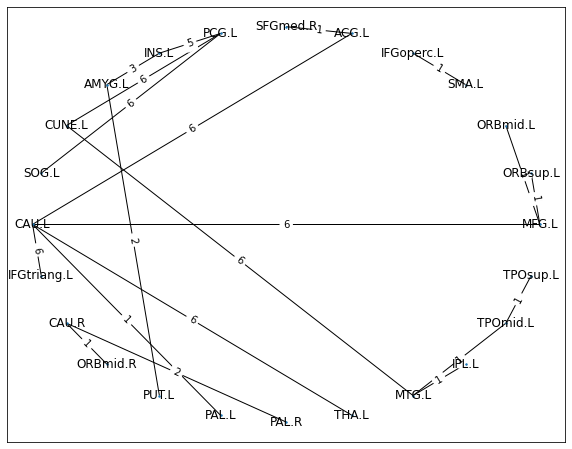

In [20]:
import networkx as nx
plt.figure(figsize=(10,8))
common_significant_features=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in combinations_without_zeros[np.unique(np.concatenate(significant_features),return_counts=True)[0]]],weight_list=np.unique(np.concatenate(significant_features),return_counts=True)[1])
pos=nx.circular_layout(common_significant_features)
nx.draw_networkx(common_significant_features,pos,node_size=2)
labels=nx.get_edge_attributes(common_significant_features,'weight')
nx.draw_networkx_edge_labels(common_significant_features,pos,edge_labels=labels)
plt.show()

In [22]:
from sklearn.linear_model import LinearRegression
def plot_the_univariate_significant_features(f,axes,p_threshold):

    X=adjusted_european_connectivity_schizophrenia
    X=StandardScaler().fit_transform(X)
    y=adjusted_european_PRS_schizophrenia[:,p_threshold]
    y=StandardScaler().fit_transform(y.reshape(-1,1))

    for idx,ax in enumerate(np.concatenate(axes)):
        ax.plot(X[:,significant_features[p_threshold][idx]],y,'.')
        
        lin_reg=LinearRegression()
        lin_reg.fit(X[:,significant_features[p_threshold][idx]].reshape(-1,1),y)
        X_pred=np.linspace(np.min(X[:,significant_features[p_threshold][idx]]),np.max(X[:,significant_features[p_threshold][idx]]),50).reshape(-1,1)
        y_pred=lin_reg.predict(X_pred)
        ax.plot(X_pred,y_pred,'r-')

        title_text=','.join([combinations_without_zeros[significant_features[p_threshold][idx]],
    'p:'+str(np.round(p_value_dict[p_threshold][significant_features[p_threshold][idx]],3)),
    'r:'+str(np.round(preprocessing.lower_triangle(np.corrcoef(X[:,significant_features[p_threshold][idx]],y.reshape(-1,1),rowvar=False),2)[0],3))])
        ax.set_title(title_text,fontdict={'fontsize':10})
        if 'CAU' in combinations_without_zeros[significant_features[p_threshold][idx]]:
            ax.set_title(title_text,fontdict={'fontsize':10},color='red')

    f.suptitle('Threshold p-value '+schizophrenia_high_scores_european.columns[p_threshold+1],size='xx-large')
    
    return 


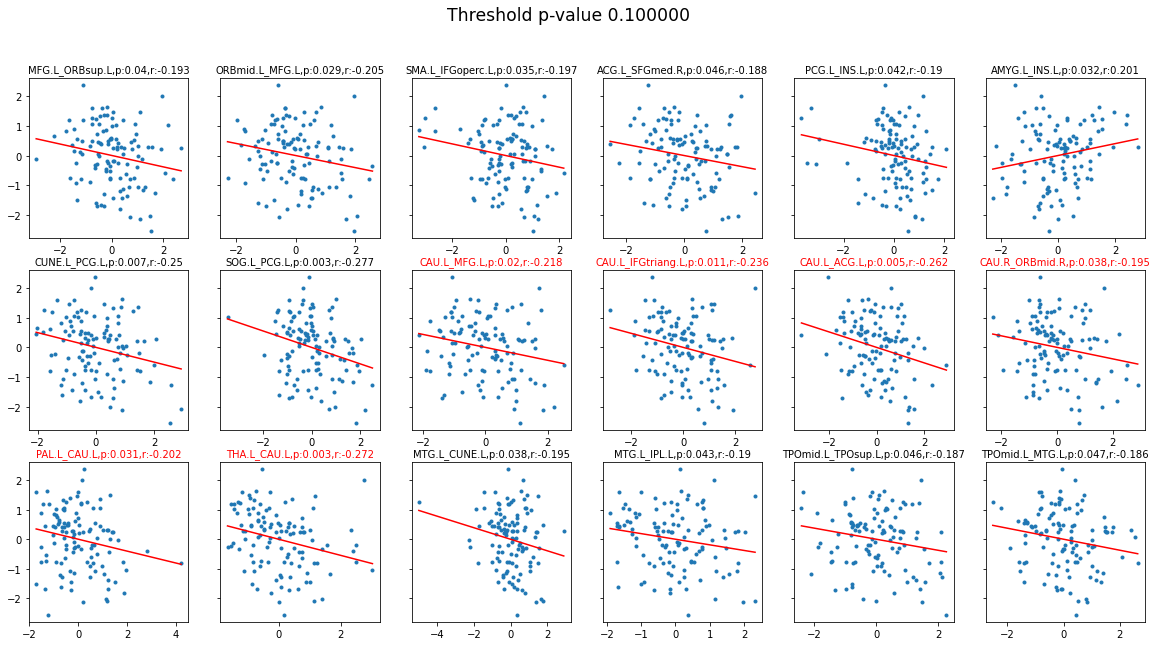

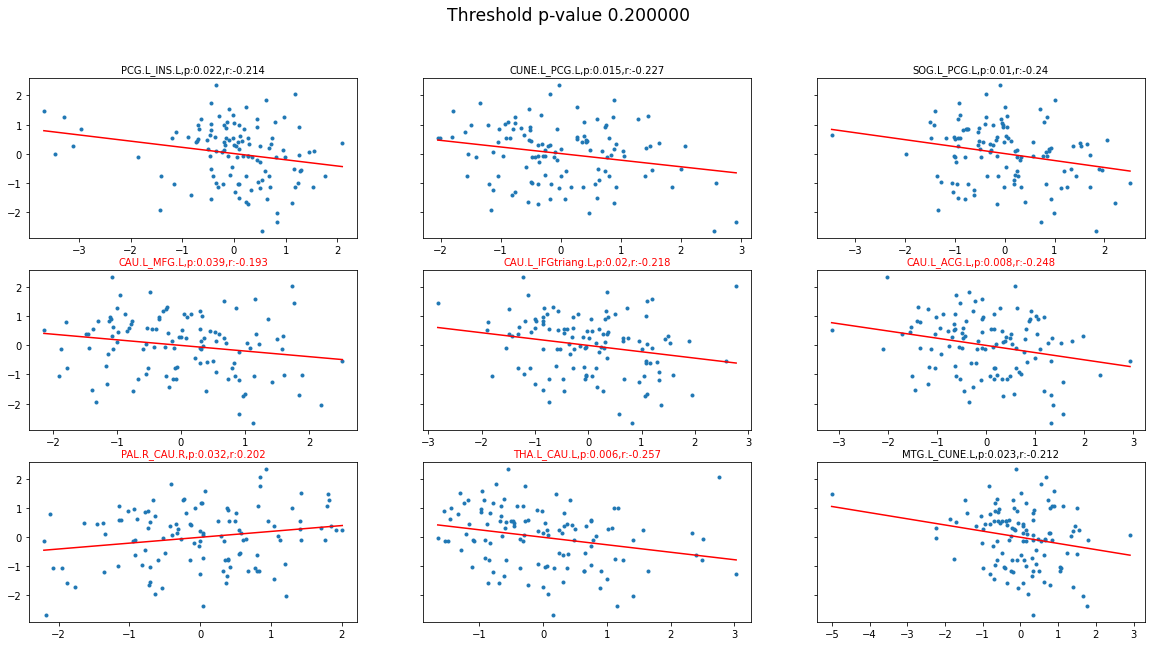

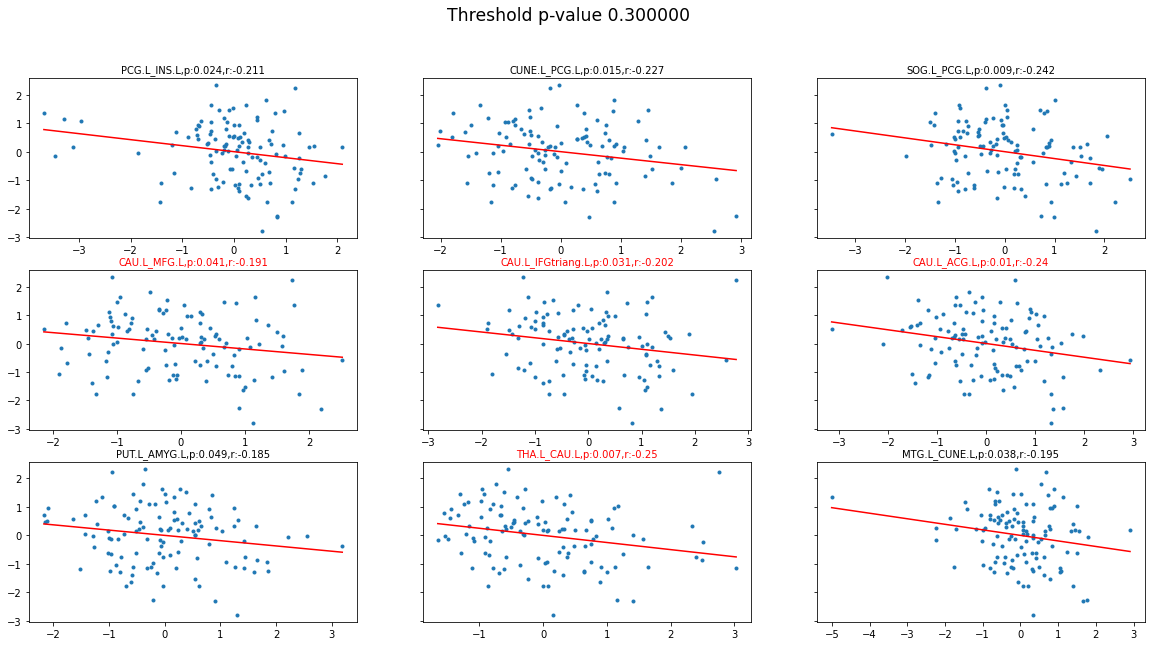

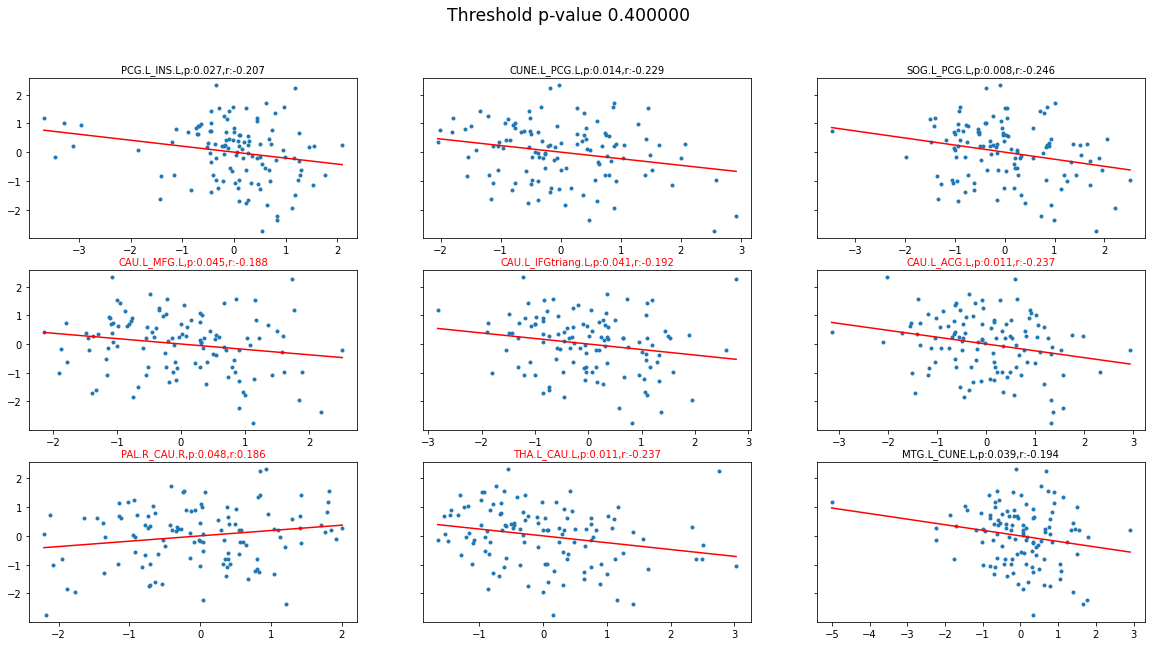

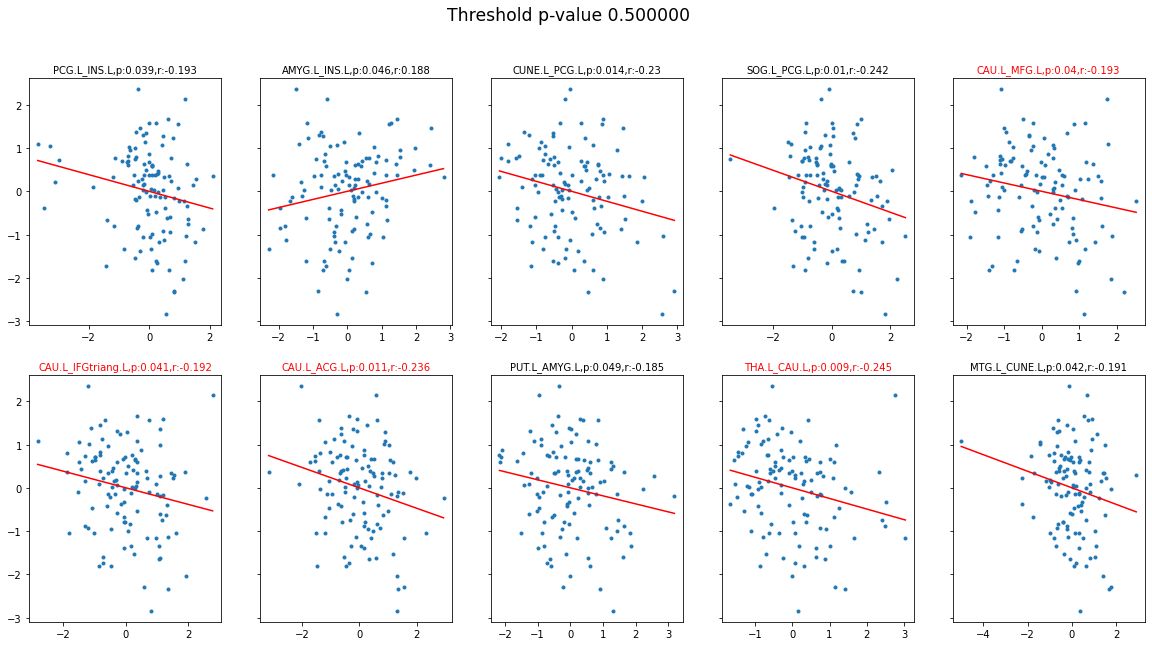

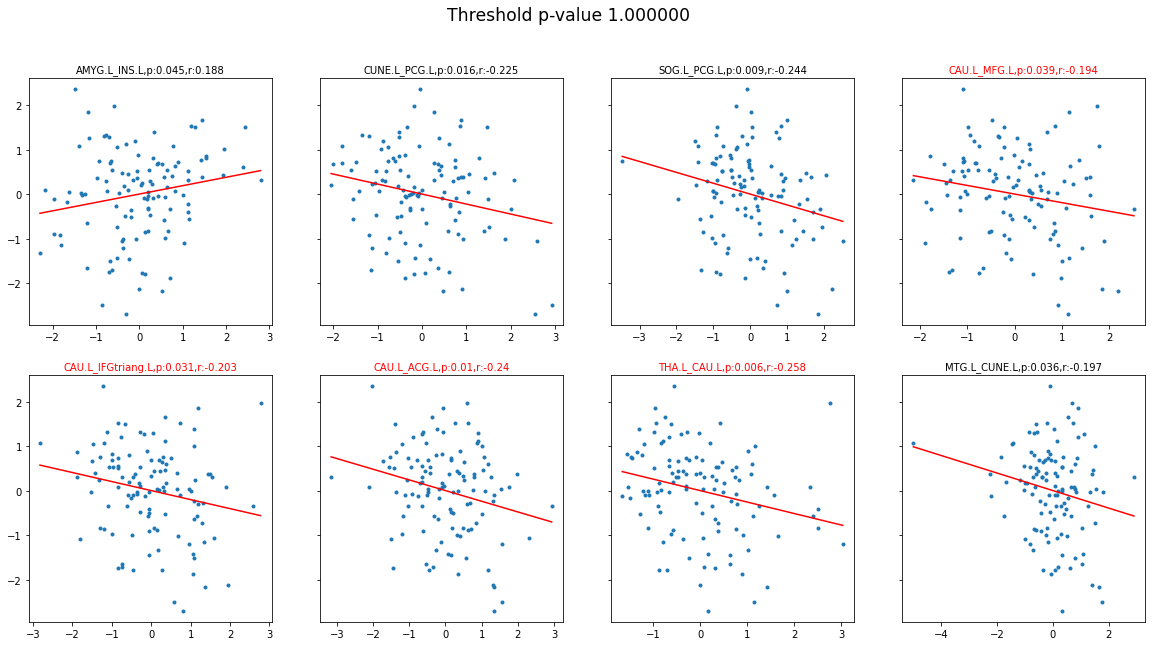

In [23]:
f,axes=plt.subplots(3,6,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,0)

f,axes=plt.subplots(3,3,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,1)

f,axes=plt.subplots(3,3,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,2)

f,axes=plt.subplots(3,3,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,3)

f,axes=plt.subplots(2,5,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,4)

f,axes=plt.subplots(2,4,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,5)

The features appears to be primarily from the left side. 

* With the Caudate both L and R side having a high number of repeated connections across the threshold. Caudate forms the medial part of the striatum and has clear involvement with both cognitive and motor functions. Damage to this structure has been reported to produce a 'schizophrenia-like' state. Caudate is a dense subcortical nucleus, composed of spiny neurons and forms the dorsal striatum along with the putamen.  It recieves projections all the way from the dorsolateral prefrontal cortex and the premotor cortex, and in turn sends projections to the globus pallidus and reciprocal projections to the substantia nigra. There are complex and reciprocal connection between thalamic nuclei and caudate.
    * Caudate - Thalamus: this is part of the striatal-nigro-striatal pathway
    * Caudate - Middle Frontal Gyrus, Inferior Frontal Gyrus 
    * Caudate - Pallidum
    * Caudate - Anterior Cingulate Gyrus
* Posterior Cingulate Gyrus (PCG) also has 2 connection to Cunneus and 


## High vs Low Risk 

I divide the **raw** PRS score into 2 groups, retaining only the top and bottom x%. And repeat the same procedure

In [14]:
#UNIVARIATE TESTING. Calculated by first estimating fitting a simple linear model to each regressor, and then calculate the R2. From R2, we calculate the F-score and with that P-value. The False discovery rate method adjust the p-value.

from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import fdrcorrection

print('#################connectivity######################')
p_value_dict={}
for p_threshold in range(adjusted_european_PRS_schizophrenia.shape[1]):

    low_risk,high_risk=preprocessing.high_low_risk_divide(european_prs_schizophrenia[:,p_threshold+1],bins=100,percentage=0.2)
    X_low_risk=adjusted_european_connectivity_schizophrenia[low_risk,:]
    X_high_risk=adjusted_european_connectivity_schizophrenia[high_risk,:]
    X=np.vstack((X_low_risk,X_high_risk))
    X=StandardScaler().fit_transform(X)
    y=np.concatenate((np.zeros(X_low_risk.shape[0]),np.ones(X_high_risk.shape[0])))

    F_score,p_value=f_classif(X,y)
    p_value_dict[p_threshold]=p_value
    survived_idx=np.where(p_value<=0.000251748146207542)[0]
    print('For threshold of %s, %d features were significant, but %d survived the correction' %(schizophrenia_high_scores_european.columns[p_threshold+1],
    len(p_value[p_value<0.05]),len(np.where(survived_idx)[0])))

#################connectivity######################
For threshold of 0.100000, 12 features were significant, but 0 survived the correction
For threshold of 0.200000, 2 features were significant, but 0 survived the correction
For threshold of 0.300000, 3 features were significant, but 0 survived the correction
For threshold of 0.400000, 3 features were significant, but 0 survived the correction
For threshold of 0.500000, 6 features were significant, but 0 survived the correction
For threshold of 1.000000, 6 features were significant, but 0 survived the correction


In [15]:
significant_features=[]
for keys,values in p_value_dict.items():
    significant_features.append(np.where(values<=0.05)[0])

In [16]:
np.unique(np.concatenate(significant_features),return_counts=True)

(array([  6,  12,  82,  95, 182, 220, 298, 322, 406, 408, 418, 424, 431,
        518, 522, 542, 570, 691, 717]),
 array([3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 6, 2, 2, 1]))

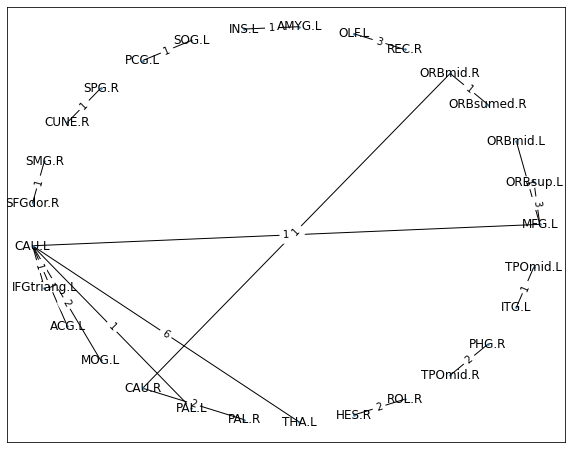

In [24]:
plt.figure(figsize=(10,8))
common_significant_features=visualisation.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in combinations_without_zeros[np.unique(np.concatenate(significant_features),return_counts=True)[0]]],weight_list=np.unique(np.concatenate(significant_features),return_counts=True)[1])
pos=nx.circular_layout(common_significant_features)
nx.draw_networkx(common_significant_features,pos,node_size=2)
labels=nx.get_edge_attributes(common_significant_features,'weight')
nx.draw_networkx_edge_labels(common_significant_features,pos,edge_labels=labels)
plt.show()

In [353]:
def plot_violin_the_univariate_significant_features(f,axes,p_threshold):

    low_risk,high_risk=preprocessing.high_low_risk_divide(european_prs_schizophrenia[:,p_threshold+1],bins=100,percentage=0.2)
    X_low_risk=adjusted_european_connectivity_schizophrenia[low_risk,:]
    X_high_risk=adjusted_european_connectivity_schizophrenia[high_risk,:]
    X=np.vstack((X_low_risk,X_high_risk))
    X=StandardScaler().fit_transform(X)
    y=np.concatenate((np.zeros(X_low_risk.shape[0]),np.ones(X_high_risk.shape[0])))
    try:
        for idx,ax in enumerate(np.concatenate(axes)):
            ax.violinplot([X[np.where(y==0)[0],significant_features[p_threshold][idx]],X[np.where(y==1)[0],significant_features[p_threshold][idx]]])
            ax.get_xaxis().set_tick_params(direction='out')
            ax.set_xticks(np.arange(1,3))
            ax.set_xticklabels(['low','high'])


            title_text=','.join([combinations_without_zeros[significant_features[p_threshold][idx]],
        'p:'+str(np.round(p_value_dict[p_threshold][significant_features[p_threshold][idx]],3))])
            ax.set_title(title_text,fontdict={'fontsize':10})
            if 'CAU' in combinations_without_zeros[significant_features[p_threshold][idx]]:
                ax.set_title(title_text,fontdict={'fontsize':10},color='red')
    except:
        for idx,ax in enumerate(axes):
            ax.violinplot([X[np.where(y==0)[0],significant_features[p_threshold][idx]],X[np.where(y==1)[0],significant_features[p_threshold][idx]]])
            ax.get_xaxis().set_tick_params(direction='out')
            ax.set_xticks(np.arange(1,3))
            ax.set_xticklabels(['low','high'])


            title_text=','.join([combinations_without_zeros[significant_features[p_threshold][idx]],
        'p:'+str(np.round(p_value_dict[p_threshold][significant_features[p_threshold][idx]],3))])
            ax.set_title(title_text,fontdict={'fontsize':10})
            if 'CAU' in combinations_without_zeros[significant_features[p_threshold][idx]]:
                ax.set_title(title_text,fontdict={'fontsize':10},color='red')
    f.suptitle('Threshold p-value '+schizophrenia_high_scores_european.columns[p_threshold+1],size='xx-large')
    
    return 


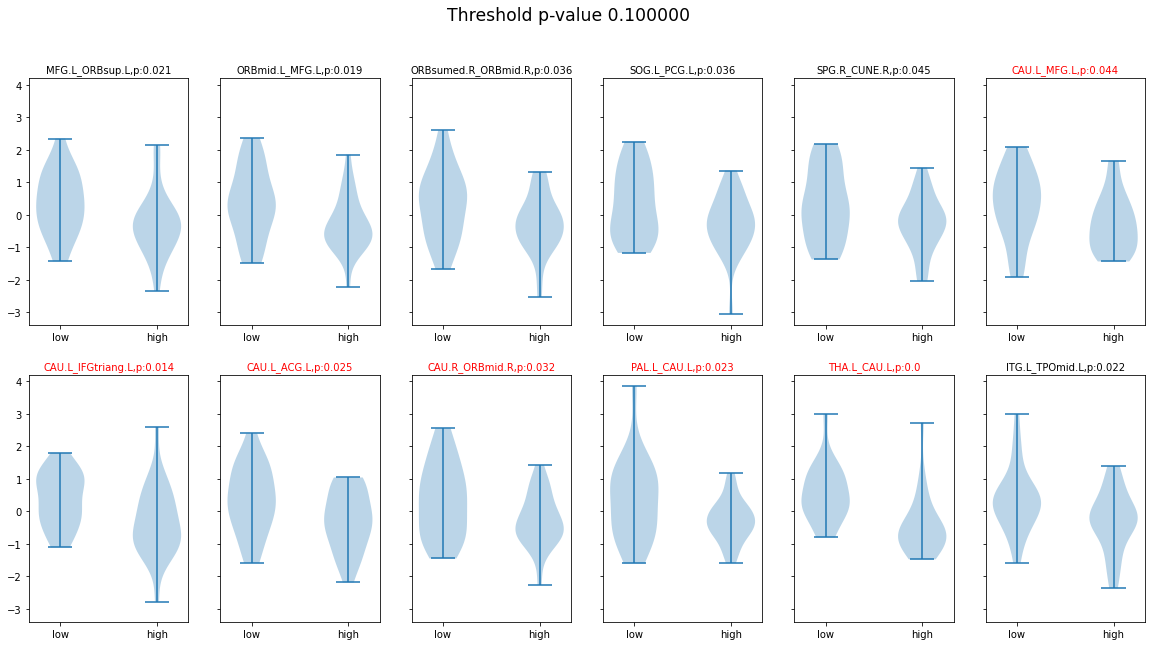

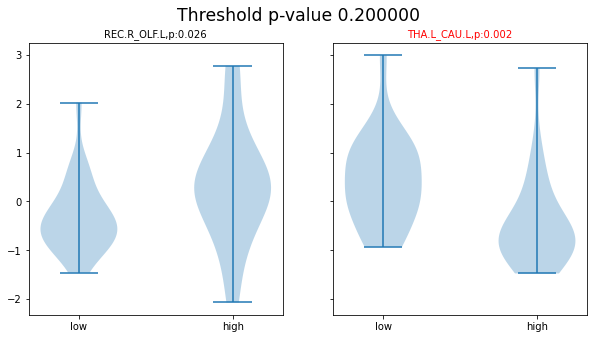

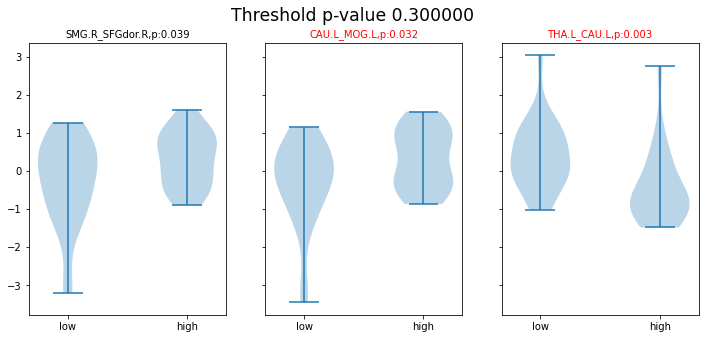

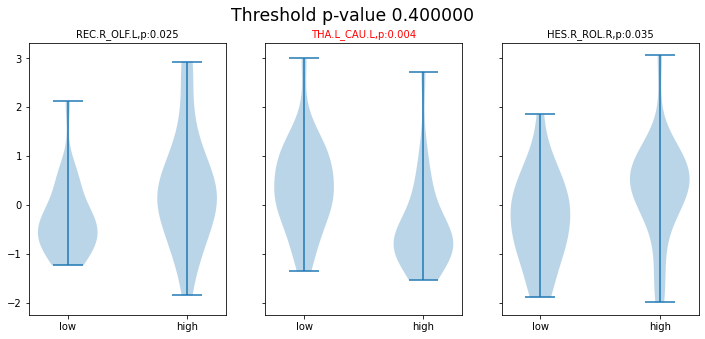

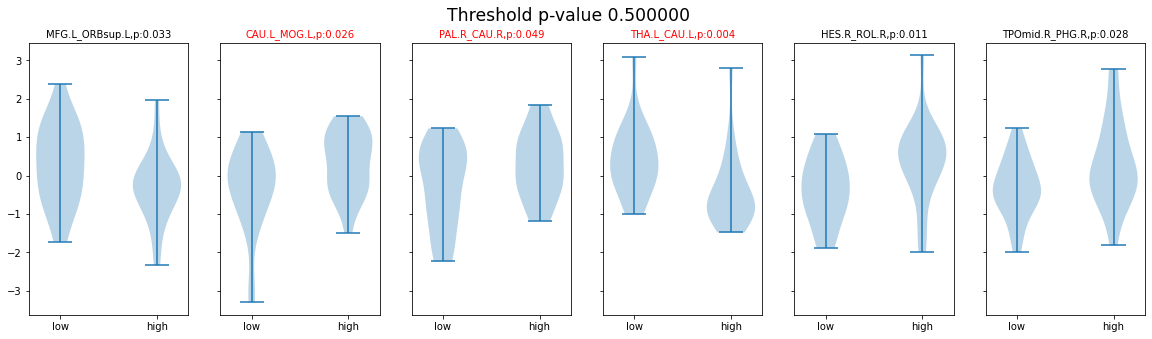

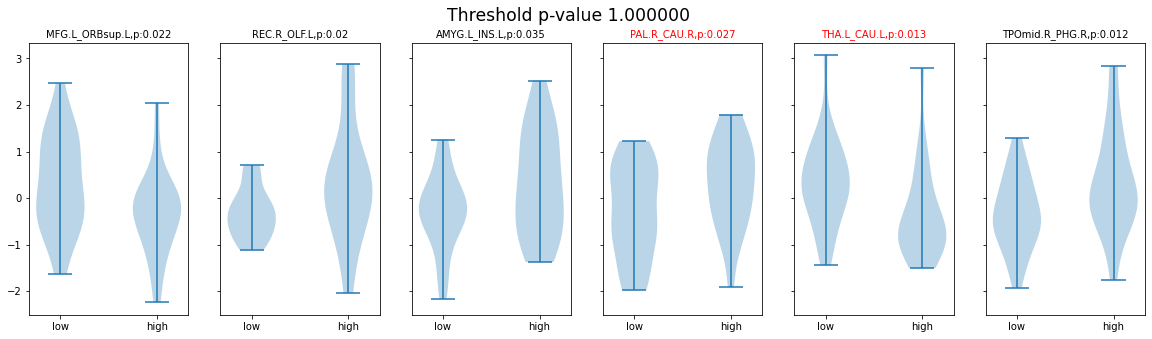

In [363]:
f,axes=plt.subplots(2,6,sharey=True,figsize=(20,10))
plot_violin_the_univariate_significant_features(f,axes,0)

f,axes=plt.subplots(1,2,sharey=True,figsize=(10,5))
plot_violin_the_univariate_significant_features(f,axes,1)

f,axes=plt.subplots(1,3,sharey=True,figsize=(12,5))
plot_violin_the_univariate_significant_features(f,axes,2)

f,axes=plt.subplots(1,3,sharey=True,figsize=(12,5))
plot_violin_the_univariate_significant_features(f,axes,3)

f,axes=plt.subplots(1,6,sharey=True,figsize=(20,5))
plot_violin_the_univariate_significant_features(f,axes,4)

f,axes=plt.subplots(1,6,sharey=True,figsize=(20,5))
plot_violin_the_univariate_significant_features(f,axes,5)